# Assignment 3: Evaluating Regression Models
## Christopher Rico
## MSDS 422

Boston Housing Study (Python)
using data from the Boston Housing Study case as described in "Marketing Data Science: Modeling Techniques for Predictive Analytics with R and Python" (Miller 2015)

Here we use data from the Boston Housing Study to evaluate regression modeling methods within a cross-validation design.

Program revised by Thomas W. Milller (2017/09/29)

Scikit Learn documentation for this assignment:
*   http://scikit-learn.org/stable/modules/model_evaluation.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
*   http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
*   http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html


# Ingest

In [0]:
#--------------------------------------------------------------------
#                       Dev Environment Setup
#--------------------------------------------------------------------

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 42

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from math import sqrt  # for root mean-squared error calculation

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_validate, cross_val_predict

In [0]:
#--------------------------------------------------------------------
#                              CORR_CHART
#       function for correlation heat map setup for seaborn
#    modified to allow for square heatmaps as well as triangle ones
#--------------------------------------------------------------------

def corr_chart(corr, tri=True):
    if tri is True:
        #screen top half to get a triangle
        top = np.zeros_like(corr, dtype=np.bool)
        top[np.triu_indices_from(top)] = True
    else:
        top = np.zeros_like(corr, dtype=np.bool)
        
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm',
        center = 0, square=True,
        linewidths=.5, cbar_kws={'shrink':.5},
        annot = True, annot_kws={'size': 9}, fmt = '.3f')
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')
    plt.savefig('plot-corr-map.pdf',
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
        orientation='portrait', papertype=None, format=None,
        transparent=True, pad_inches=0.25, frameon=None)

In [0]:
#--------------------------------------------------------------------
#                     Getting and Examining Data
#--------------------------------------------------------------------

#get data from github raw file
url = 'https://raw.githubusercontent.com/christophrico/MSDS_422/master/assign-3/boston.csv'
boston_input = pd.read_csv(url)

# add in log median value of homes as another column
boston_input['log_mv'] = np.log(boston_input['mv'])

boston_input = boston_input.rename( columns = {'mv' : 'median_value',
                                   'log_mv' : 'log_median_value',
                                   'nox' : 'air_pollution',
                                   'crim' : 'crime_rate',
                                   'zn' : 'pct_zoned_lots',
                                   'indus' : 'pct_industrial',
                                   'chas' : 'is_waterfront',
                                   'rooms' : 'avg_rooms',
                                   'age' : 'pct_pre_war',
                                   'dis' : 'avg_commute',
                                   'rad' : 'highway_access',
                                   'tax' : 'tax_rate',
                                   'ptratio' : 'pt_ratio',
                                   'lstat' : 'pct_poor'})

# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
print(boston_input.head())
print(boston_input.tail())


boston DataFrame (first and last five rows):
  neighborhood  crime_rate  ...  median_value  log_median_value
0       Nahant     0.00632  ...          24.0          3.178054
1   Swampscott     0.02731  ...          21.6          3.072693
2   Swanpscott     0.02729  ...          34.7          3.546740
3   Marblehead     0.03237  ...          33.4          3.508556
4   Marblehead     0.06905  ...          36.2          3.589059

[5 rows x 15 columns]
    neighborhood  crime_rate  ...  median_value  log_median_value
501     Winthrop     0.06263  ...          22.4          3.109061
502     Winthrop     0.04527  ...          20.6          3.025291
503     Winthrop     0.06076  ...          23.9          3.173878
504     Winthrop     0.10959  ...          22.0          3.091042
505     Winthrop     0.04741  ...          19.0          2.944439

[5 rows x 15 columns]


In [0]:
print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())


General description of the boston_input DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
neighborhood        506 non-null object
crime_rate          506 non-null float64
pct_zoned_lots      506 non-null float64
pct_industrial      506 non-null float64
is_waterfront       506 non-null int64
air_pollution       506 non-null float64
avg_rooms           506 non-null float64
pct_pre_war         506 non-null float64
avg_commute         506 non-null float64
highway_access      506 non-null int64
tax_rate            506 non-null int64
pt_ratio            506 non-null float64
pct_poor            506 non-null float64
median_value        506 non-null float64
log_median_value    506 non-null float64
dtypes: float64(11), int64(3), object(1)
memory usage: 59.4+ KB
None


In [0]:
# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())


General description of the boston DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crime_rate          506 non-null float64
pct_zoned_lots      506 non-null float64
pct_industrial      506 non-null float64
is_waterfront       506 non-null int64
air_pollution       506 non-null float64
avg_rooms           506 non-null float64
pct_pre_war         506 non-null float64
avg_commute         506 non-null float64
highway_access      506 non-null int64
tax_rate            506 non-null int64
pt_ratio            506 non-null float64
pct_poor            506 non-null float64
median_value        506 non-null float64
log_median_value    506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB
None


In [0]:
print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


Descriptive statistics of the boston DataFrame:
       crime_rate  pct_zoned_lots  ...  median_value  log_median_value
count  506.000000      506.000000  ...    506.000000        506.000000
mean     3.613524       11.363636  ...     22.528854          3.034558
std      8.601545       23.322453  ...      9.182176          0.408275
min      0.006320        0.000000  ...      5.000000          1.609438
25%      0.082045        0.000000  ...     17.025000          2.834680
50%      0.256510        0.000000  ...     21.200000          3.054001
75%      3.677082       12.500000  ...     25.000000          3.218876
max     88.976200      100.000000  ...     50.000000          3.912023

[8 rows x 14 columns]


# EDA

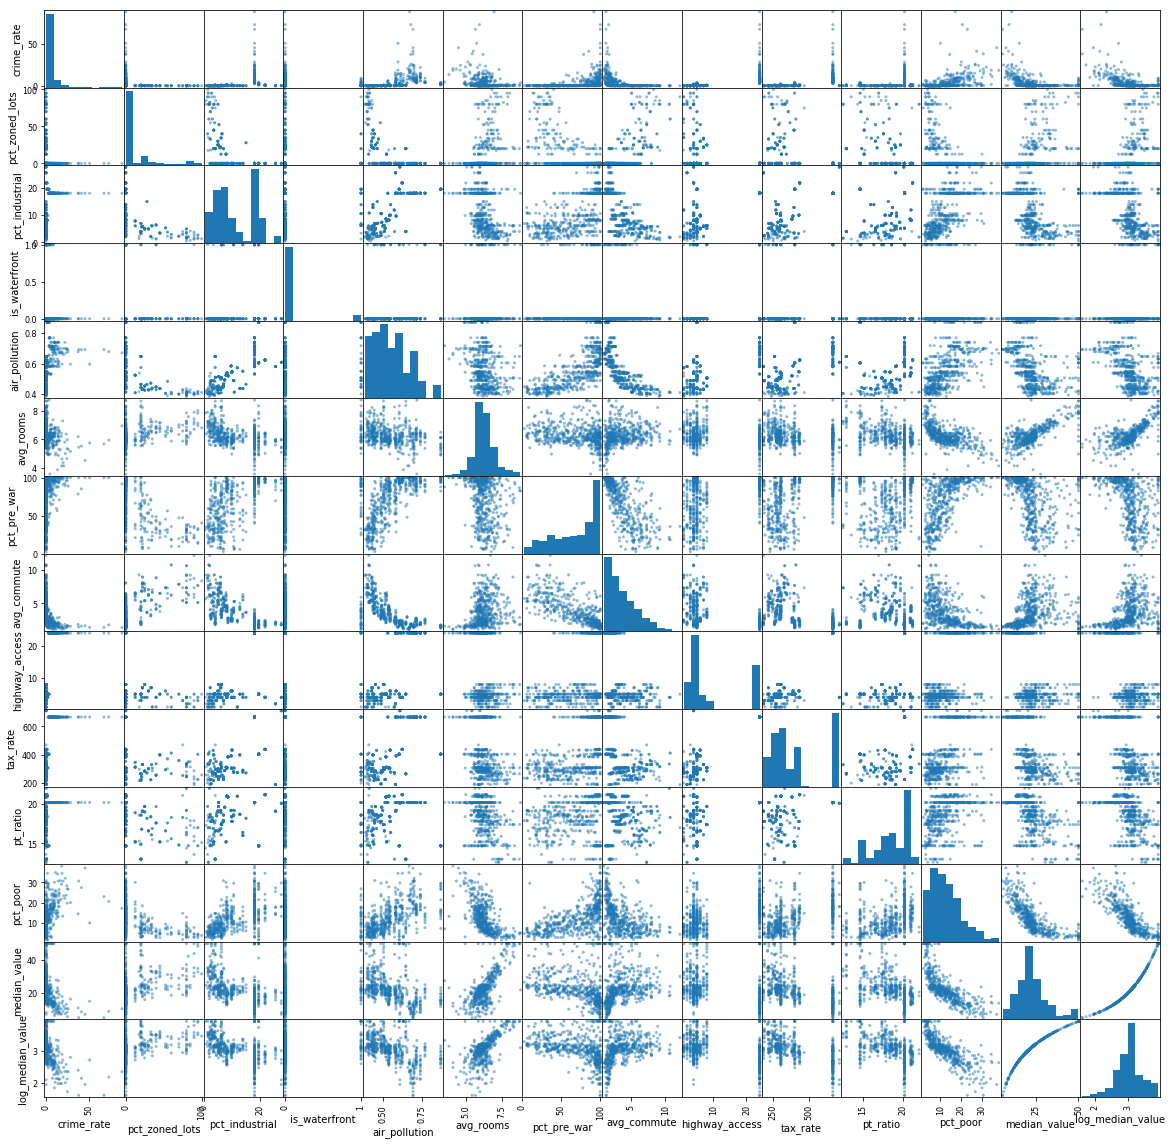

In [0]:
# plot a scatter matrix to see what kinds of patterns emerge in data
pd.plotting.scatter_matrix(boston, diagonal='hist', figsize=(20,20)); plt.show()

<Figure size 432x288 with 0 Axes>

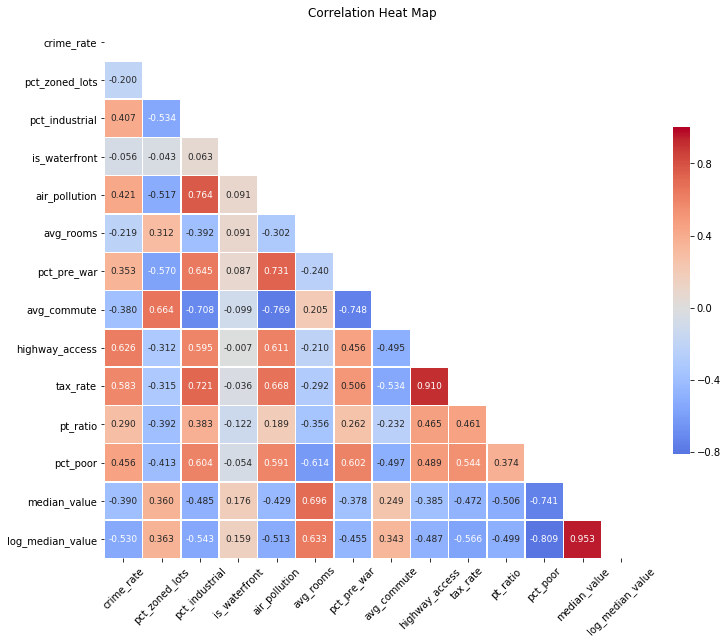

In [0]:
#plot a correlation heatmap as a way to see any numerical intercorrelations
house_corr = boston.corr()
corr_chart(house_corr)

In [0]:
#sort so strongest positive correlations are at top
#and strongest negative correlations are at bottom for median home values
print(house_corr.loc['crime_rate':'pct_poor','median_value':'median_value']\
      .sort_values(by='median_value', ascending=False))

                median_value
avg_rooms           0.696304
pct_zoned_lots      0.360386
avg_commute         0.249315
is_waterfront       0.175663
pct_pre_war        -0.377999
highway_access     -0.384766
crime_rate         -0.389582
air_pollution      -0.429300
tax_rate           -0.471979
pct_industrial     -0.484754
pt_ratio           -0.505655
pct_poor           -0.740836


In [0]:
#and do the same for the log median home vaues
print(house_corr.loc['crime_rate':'pct_poor','log_median_value':'log_median_value']\
      .sort_values(by='log_median_value', ascending=False))


                log_median_value
avg_rooms               0.632536
pct_zoned_lots          0.363396
avg_commute             0.342527
is_waterfront           0.158569
pct_pre_war            -0.455029
highway_access         -0.486818
pt_ratio               -0.499433
air_pollution          -0.513431
crime_rate             -0.530001
pct_industrial         -0.543195
tax_rate               -0.566214
pct_poor               -0.809234


# Modeling

In [0]:
#--------------------------------------------------------------------
#                Model Setup: Data Preprocessing
#--------------------------------------------------------------------

# set up preliminary data for data for fitting the models 
prelim_model_data = np.array([boston.crime_rate,
                              boston.pct_zoned_lots,
                              boston.pct_industrial,
                              boston.is_waterfront,
                              boston.air_pollution,
                              boston.avg_rooms,
                              boston.pct_pre_war,
                              boston.avg_commute,
                              boston.highway_access,
                              boston.tax_rate,
                              boston.pt_ratio,
                              boston.pct_poor
                             ]).T

print('\nData dimensions:', prelim_model_data.shape)


Data dimensions: (506, 12)


In [0]:
# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

StandardScaler(copy=True, with_mean=True, with_std=True)
[3.61352356e+00 1.13636364e+01 1.11367787e+01 6.91699605e-02
 5.54695059e-01 6.28463439e+00 6.85749012e+01 3.79504269e+00
 9.54940711e+00 4.08237154e+02 1.84555336e+01 1.26530632e+01]
[8.59304135e+00 2.32993957e+01 6.85357058e+00 2.53742935e-01
 1.15763115e-01 7.01922514e-01 2.81210326e+01 2.10362836e+00
 8.69865112e+00 1.68370495e+02 2.16280519e+00 7.13400164e+00]


In [0]:
# the model data will be standardized form of preliminary model data
X = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', X.shape)


Dimensions for model_data: (506, 12)


In [0]:
#--------------------------------------------------------------------
#                           cv_chart
# Function to make scatterplot predicted vs actual reponse variables
# Input: predicted, a numpy array of predicted response vars
#        y, a numpy array of actual response vars
#        regre_name, a list of regressor names (for printing)
# Output: Scatterplot with line of predicted vs actual y 
# Adapted from Scikit-Learn documentation
#--------------------------------------------------------------------
def cv_chart(predicted, y, regre_name):
  fig, ax = plt.subplots()
  ax.scatter(y, predicted, edgecolors=(0, 0, 0))
  ax.plot([y.min(), y.max()], [predicted.min(), predicted.max()], 'k--', lw=4)
  ax.set_title("{} Measured vs Predicted Values".format(regre_name))
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

In [0]:
#--------------------------------------------------------------------
#                           cv_compare_regressors
# Function to automate cross-fold validation between various regression models
# Input: X_data, numpy array of explanatory data
#        y_data, numpy array of response data
#        regressor_names, list of regressor names for printing
#        regressors, list of sklearn regressor instances to compare
#        n_folds, int for the number of folds you want to run (default 5)
# Output: RMSE per regressor, chart of predicted vs actual y
# Adapted from Scikit-Learn documentation
#--------------------------------------------------------------------
def cv_compare_regressors(X_data, y_data, regressor_names, regressors, n_folds=5):
  #set up dataframe to collect results
  results = pd.DataFrame(columns=['Regressor', 'Train_RMSE', 'Test_RMSE', 'Diff'])

  #compare the regressors across 10 different folds
  for name, reg in zip(regressor_names, regressors):

    #perform the cross validation
    cv_res = cross_validate(reg, X_data, y_data, cv=10,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True
                            )

    #and make chart of each predicted vs measured output
    y_pred = cross_val_predict(reg, X_data, y_data, cv=n_folds)
    cv_chart(y_pred, y_data, name)

    #calculate the training rmse
    train_mse = abs( np.mean( cv_res['train_neg_mean_squared_error'] ) )
    train_rmse = sqrt(train_mse)
    #calculate the test rmse
    test_mse = abs( np.mean( cv_res['test_neg_mean_squared_error'] ) )
    test_rmse = sqrt(test_mse)
    #calculate the diff between the two
    diff = test_rmse - train_rmse

    #save the results into a dataframe
    results = results.append( {
                                'Regressor' : name,
                                'Train_RMSE' : train_rmse,
                                'Test_RMSE' : test_rmse,
                                'Diff' : diff
                              },
                              sort=False,
                              ignore_index=True
                              )
    #end loop

  display(results)

In [0]:
#--------------------------------------------------------------------
#             Model Setup: Linear, Ridge, Lasso, and Elastic Net
#--------------------------------------------------------------------

#instantiate the regressors we want to use
#let's try linear, lasso, and elastic net
lin_reg = LinearRegression(fit_intercept=True)
ridge_reg = Ridge(alpha = 0.1,
                  solver = 'cholesky',
                  fit_intercept = True,
                  normalize = False,
                  random_state = RANDOM_SEED)
lasso_reg = Lasso(alpha=0.1,
                  max_iter=10000,
                  tol=0.01,
                  fit_intercept=True,
                  random_state=RANDOM_SEED)
en_reg = ElasticNet(alpha=0.1,
                    l1_ratio=0.2,
                    max_iter=10000,
                    tol=0.01,
                    fit_intercept=True,
                    normalize=False,
                    random_state=RANDOM_SEED)

regressors = [lin_reg, ridge_reg, lasso_reg, en_reg]
regressor_names = ['Linear', 'Ridge', 'Lasso', 'Elastic Net']

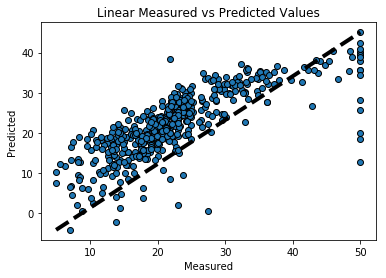

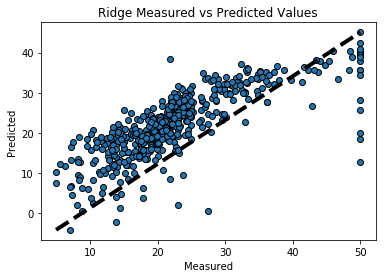

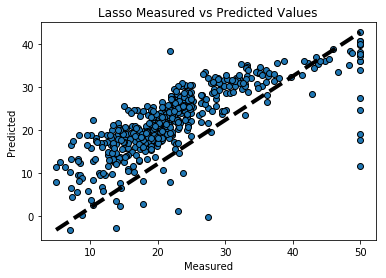

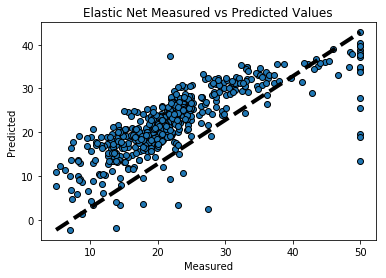

,Regressor,Train_RMSE,Test_RMSE,Diff
0,Linear,4.642660,5.796693,1.154033
1,Ridge,4.642662,5.795697,1.153035
2,Lasso,4.697420,5.793183,1.095763
3,Elastic Net,4.720729,5.631707,0.910978


In [0]:
#--------------------------------------------------------------------
#                Model Setup: K-Fold Comparison
#--------------------------------------------------------------------
#we are going to use median_value as a response variable
y = np.array([boston.median_value]).T

#compare the models across 10 folds of data
cv_compare_regressors(X, y, regres_names, regres, 10)

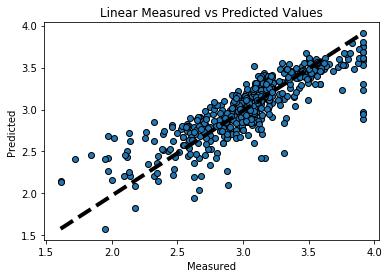

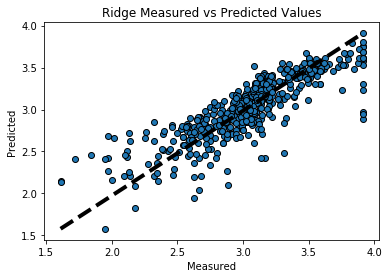

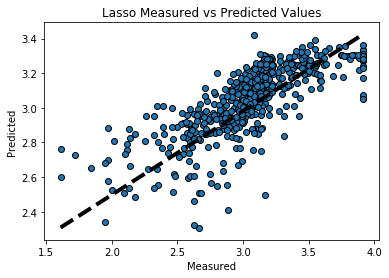

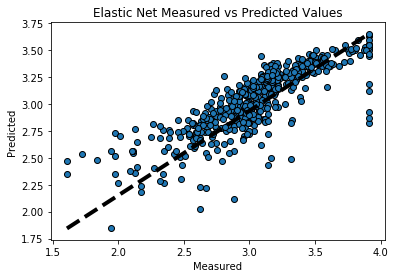

,Regressor,Train_RMSE,Test_RMSE,Diff
0,Linear,0.185761,0.223353,0.037592
1,Ridge,0.185761,0.223338,0.037577
2,Lasso,0.245910,0.286836,0.040926
3,Elastic Net,0.204515,0.235950,0.031435


In [0]:
#now let's try to use log_median_value as a response variable
y = np.array([boston.log_median_value]).T

#compare the models across 10 folds of data
cv_compare_regressors(X, y, regres_names, regres, 10)

# Conclusion

Recommended regression modeling technique is ridge regression while using the log of the median home values as a response variable. 

This regressor strikes a good balance between tightness of fit, while still avoiding the predictive error that other models exhibit for higher-priced homes. The Root Mean Square Error of ridge regression is marginally better than those of other models when using log_median_value as a response variable.